# Modulation Classification Using SNNs based on the ESBP Algorithm

The code is based on the paper by 2020,Chankyu Lee et.all, <i>Enabling Spike-Based Backpropagation for Training Deep Neural Network Architecture</i>

In [1]:
import torch 
import torch.nn
import matplotlib.pyplot as plt 
import pickle
import h5py
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding
from tqdm import tqdm

## 0.  Define the helper's functions used in SNNs


In [2]:
def aux_spike_activity(spike, ref_spike,tmp = 100,T=100,isPlot = True):
    '''
    calculate the continous real value spike activity based on the equation 4
    from paper Lee.et.al (2016)
    output : tensor/vector of accumulated effects of spike at the final observation time T
    input  : spike, spike activity representd in 1 or 0
    input  : ref_spike, the reference function to save computational time
    input  : tmp, time constant of decaying spike signal
    input  : T, observation time
    '''
    dt = torch.linspace(0,T-1,T) #the time axis
    xk   = torch.zeros(spike.shape) #variable to store continous real value of accummulated. spike signal    
    
    """ if (ref_spike == None):
        y = torch.exp(-dt/tmp)
    else:
        y = ref_spike    """
    y = ref_spike
    sidx = (spike).nonzero().numpy() #get the index of the spike

    # plot the binary spike activity
    if isPlot:        
        spikes = {"A":spike}
        plt.figure()
        plot_spikes(spikes)

    # calculate the accumulated spike activity    
    for id,val in enumerate(sidx):
        if val[0]==0:
            xk[:,val[1]] = np.add(xk[:,val[1]],y)
        else:
            xk[:,val[1]] = np.add(xk[:,val[1]],[*np.zeros(val[0]),*y[0:-val[0]]])
    xk = -1*xk / tmp
    # plot the spike signal
    if isPlot:      
        plt.figure(figsize=[10,5])
        plt.plot(dt,xk)
        plt.title("Accumulated spike activity")
        plt.xlabel("Time Steps")
        #put some legend :)
        list_legend = []
        for i in range(spike.size(1)):
            list_legend.append('neuron %s'%i)
        plt.legend((list_legend),loc='best')
        plt.show()
    # return the last value of accum spike activity    
    return xk[-1,:]


## 1. Build the SNNs to carry out the task of Amplitude Modulation detection

In [3]:
#define the number of neuron in each layer
nodes = [2,20,4]

Time = 100 #training and inference time duration for each example
tau_m = 100 #time constant
T_ref = 1 #refractory period of neuron
delta_v = [7,55]
v_rest = -65
V_th =[-62,-10] #voltage threshold of neuron
V_th1 = V_th[0]+torch.zeros(1,nodes[1]) #voltage threshold for hidden layer 
V_th2 = V_th[1]+torch.zeros(1,nodes[2]) #voltage threshold for hidden layer
k = 2 #weight initialization constant

#define the network object
network = Network()
#define the type of layer
source_layer = Input(n=nodes[0],traces=True)
hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=V_th1,tc_decay=tau_m,sum_input=False,lbound=v_rest - delta_v[0])
target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=V_th2,tc_decay=tau_m,sum_input=False,lbound=v_rest - delta_v[1])
#adding layer to the network
network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)

#define the connection for each layer
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #weight initialization according to Lee et.al 
    w = torch.abs(torch.normal(mean=0,std=np.sqrt(1/(nodes[0]+5)),size=(source_layer.n, hidden_layer.n)))    
)
network.add_connection(
    connection=forward_connection1, source="A", target="B"
)
#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #weight initialization according to Lee et.al    
    w = torch.abs(torch.normal(mean=0,std=np.sqrt(k/nodes[1]),size=(hidden_layer.n, target_layer.n)))    
)
network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = Time , 
)
hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = Time ,
)
target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = Time ,
)
#add the monitor to the network
network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")

## 2. Generate Amplitude Modulation Datasets

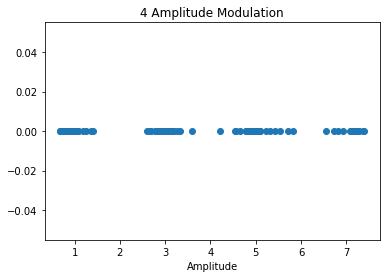

In [4]:
#generate the data 4 level of amplitude modulation
M = 4 #number of amplitude level
N_samples = 100 #number of training sample

s = np.random.randint(M, size= N_samples) #generate N random symbols

c = s * 2 + 1 #assign symbol to a certain amplitude level
n = np.random.normal(0,0.25,N_samples) #random gaussian noise
z = c + n #signal plus noise

#convert to torch tensor
s = torch.from_numpy(s)
z = torch.from_numpy(z)
#plot
y_ax = np.zeros(N_samples)
plt.scatter(z,y_ax)
plt.title('%d Amplitude Modulation'%M)
plt.xlabel('Amplitude')
plt.show()

### 2.1 Convert the Amplitude Modulation Datasets into spike train
Each amplitude level is converted into poisson distributed spike train. The spike rate of each train is determined <br> 
by the amplitude level. It is intentionally to make the final layer does not output any spike by setting voltage <br>
threshold to be very high. The classification instead is carried out by calculating the internal voltage of the neuron.

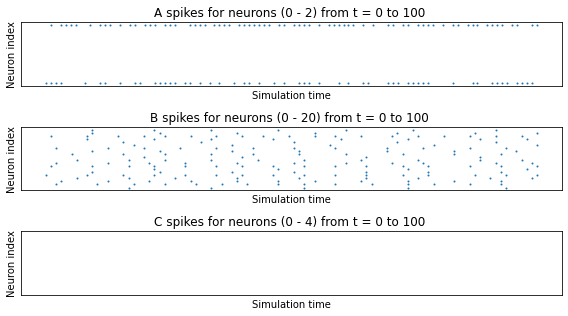

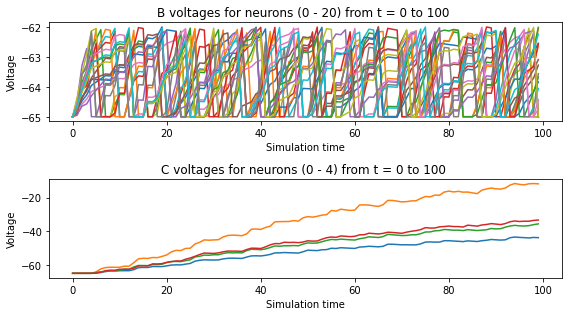

In [5]:
network.layers["C"].reset_state_variables() #reset neuron internal voltage
network.layers["B"].reset_state_variables() #reset neuron internal voltage   
#convert all the amplitude data into the spike rate
input_data = torch.zeros(N_samples*Time,nodes[0])
for i,val in enumerate(z):
    #print(i,val,y[i])
    rate = torch.tensor([[val*200],[(2*M-val)*200]]).squeeze() #convert amplitude to spike rate
    #convert into poisson distributed spike train
    input_data[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 

y = torch.nn.functional.one_hot(torch.tensor(s))  #convert label to one hot encoding

#feed the input spike train into the network
#run the network
j = np.random.choice(N_samples) #randomly choose the index of input data
inputs = {'A':input_data[j*Time:(j*Time)+Time,:]}
network.run(inputs=inputs , time=Time)
#record spike activit and neuron voltage
spikes = {
    "A": network.monitors['A'].get('s'), 
    "B": network.monitors['B'].get("s"),
    "C": network.monitors['C'].get("s"),
}
voltages = {"B": network.monitors['B'].get("v"),
            "C": network.monitors['C'].get("v")}

#plot the result
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()
#reset the voltage neuron
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()    

## 3. Train The Network using Spike-Based Gradient Descent Backpropagation Algorithm

the following are the procedure to do Backpropagation Algorithm <br>
1. Forward propagation the input train spike into the Network <br>
2. Backward propagate the error from last layer to hidden layer <br>
3. Update the weights based on the errror gradient <br>


In [6]:


dt = torch.linspace(0,Time-1,Time) #the time axis
ref_spike = torch.exp(-dt/tau_m) ##spike referrence

num_epoch = 125 #number of epochs
learn_rate = 0.05 #the learning rate
L = torch.zeros(num_epoch)
l = torch.zeros(N_samples)
ACC = torch.zeros(num_epoch)
y_pred = torch.zeros(N_samples)
#l = 0

#the learning loop
for epoch in range(num_epoch): #loop for every epochs
    for sample in tqdm(range(N_samples)): #loop for every training sample
        #1. run forward propagation 
        inputs = {"A":input_data[sample*Time:(sample*Time)+Time,:]} #fetch the training sample
        label = y[sample,:] #fetch the correct label for the training sample
        network.run(inputs=inputs,time=Time)
        #   1.1 get the spikes and voltages information
        spikes = {
            "A": network.monitors['A'].get("s"), #spike activity at the input layer 
            "B": network.monitors['B'].get("s"), #spike activit at the hidden layer
            #"C": network.monitors['C'].get("s"),
            }
        """ voltages = {
            "B": network.monitors['B'].get("v"),#voltage neuron at hidden layer
            "C": network.monitors['C'].get("v")}#voltage neuron at output layer """
        # get the weights of the network
        w_hid = network.connections['A','B'].w          
        w_out = network.connections['B','C'].w
        gamma = torch.sum(spikes['B'].squeeze(),dim=0).float() #number of spikes train in each neuron in hidden layer outputting
        #   1.2 calculate total weighted sum of pre and post spike at hidden layer
        net_hid = torch.sum (w_hid *(torch.sum(spikes['A'])),dim=0)  #accumulated input current at hidden layer
        a_lif_hid = torch.sum(spikes['B'].squeeze(),dim=0).float()   #activation of neuron/output spi

        #   1.3 calculate total weighted sum of pre and spike trains at the output layer
        net_out = (a_lif_hid @ w_out) #accumulated input current at output layer
        #a_lif_out = (network.layers['C'].v ) #output at the last layer (cross entropy) voltage
        a_lif_out = torch.softmax(network.layers['C'].v,dim=1) #output at the last layer (cross entropy) voltage
        #print(a_lif_out)
       
        #2. Calculate the Backward Propagation
        # At the output layer
        e_out = a_lif_out - label #error at the output layer
        delta_e_out = e_out / Time  #error gradient at the output layer
        
        #calculate loss function
        l[sample] = 0.5 * torch.sum(e_out**2)
        #calculate accuracy
        #y_pred[sample] = torch.argmax(a_lif_out)
        y_pred[sample] = torch.argmax(network.layers['C'].v)

        #at the hidden layer
        f_prime = aux_spike_activity(spikes['B'].squeeze(), ref_spike,tmp = tau_m,T=Time,isPlot = False)  #calculate the spike leak activity
        leak_correct = (1 +  (1/gamma)*f_prime)
        da_lif_hid = (1/network.layers['B'].thresh) * leak_correct
        delta_e_hid = (w_out @ delta_e_out.T) * da_lif_hid.T #error gradient at hidden layer
        delta_e_hid[torch.where(torch.isnan(delta_e_hid)==True)] = 0
        

        #3. Update the weights
        #update_weights()
        X_out = torch.sum(spikes['B'],dim=0).float()
        X_hid = torch.sum(spikes['A'],dim=0).float()
        delta_w_out = -learn_rate * (X_out.T @ delta_e_out)     #gradient of weigth at the output layer 
        delta_w_hid = -learn_rate * (X_hid.T @ delta_e_hid.T)   #gradient of weight at the hidden layer

        w_out.add_(delta_w_out)
        w_hid.add_(delta_w_hid) 

        #4.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()  

    L[epoch] = torch.sum(l)/N_samples
    ACC[epoch] = (torch.sum(y_pred==s)*100)/N_samples
    #print epochs and loss
    print("epochs %d, loss=%f, acc= %1.2f %%: "%(epoch,L[epoch].item(),ACC[epoch].item()))
    if (L[epoch] < 0.025) or (ACC[epoch] >= 99.0):
        break #stop the loop


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]epochs 124, loss=0.034378, acc= 98.00 %: 



# 4. Run The Final Prediction
After the training, feed the data into the network to make final Prediction

Text(0.5, 0, 'epochs')

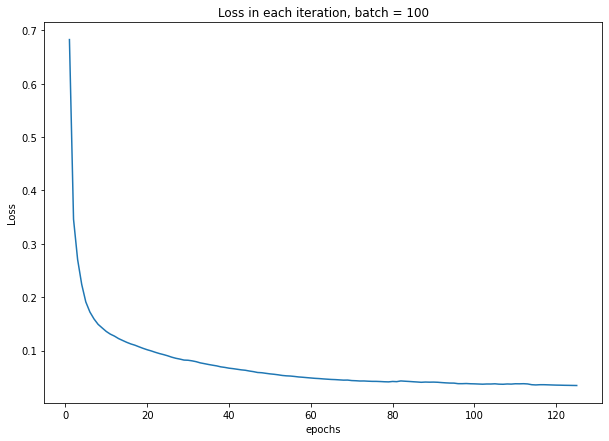

In [11]:
#plot the loss in each iteration
x_ax = np.linspace(1,len(L),len(L))
plt.figure(figsize=[10,7])
plt.plot(x_ax,L)
plt.title("Loss in each iteration, batch = %s"%N_samples)
plt.ylabel("Loss",)
plt.xlabel("epochs")

In [12]:

#run the final prediction
y_pred_run = torch.zeros(N_samples)
for j in range(N_samples):
    inputs = {"A":input_data[j*Time:(j*Time)+Time,:]}
    network.run(inputs=inputs,time=Time)
    #a_out    = network.monitors["C"].get("s").squeeze().float()
    #a_out = torch.softmax(network.layers['C'].v,dim=1)
    
    a_out = (network.layers['C'].v)
    #a_out = torch.sum(network.monitors['C'].get("s").squeeze(),dim=0)

    y_pred_run[j] = torch.argmax(a_out)
    #print(a_out)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("Output final layer ",y_pred_run)  

print("target vector %s"%s)
#calculate accuracy
accr = (torch.sum(y_pred_run==s)*100/N_samples)
print("Accuracy : "+str(accr.item())+" % ")

Output final layer  tensor([1., 1., 2., 2., 3., 1., 1., 0., 3., 1., 2., 0., 1., 1., 3., 3., 3., 2.,
        1., 0., 2., 0., 0., 1., 0., 1., 0., 2., 3., 1., 2., 3., 3., 2., 2., 3.,
        1., 1., 1., 0., 0., 3., 2., 1., 0., 0., 0., 2., 2., 3., 3., 1., 1., 0.,
        0., 3., 2., 0., 2., 3., 0., 0., 1., 2., 3., 0., 0., 0., 2., 2., 2., 1.,
        2., 1., 0., 2., 3., 1., 0., 3., 0., 0., 1., 0., 3., 1., 1., 2., 1., 1.,
        1., 3., 3., 0., 2., 1., 1., 1., 2., 3.])
target vector tensor([1, 1, 2, 2, 3, 1, 1, 0, 3, 1, 2, 0, 1, 1, 3, 3, 3, 2, 1, 0, 2, 0, 0, 1,
        0, 1, 0, 2, 3, 1, 2, 3, 2, 2, 2, 3, 1, 1, 1, 0, 0, 3, 2, 2, 0, 0, 0, 2,
        2, 3, 3, 1, 1, 0, 0, 3, 2, 0, 2, 3, 0, 0, 1, 2, 3, 0, 0, 0, 2, 2, 2, 1,
        2, 1, 0, 2, 3, 1, 0, 3, 0, 0, 2, 0, 3, 1, 1, 2, 1, 1, 1, 3, 3, 0, 2, 1,
        1, 1, 2, 3])
Accuracy : 97.0 % 


In [58]:
#save the weight of trained network
""" saved_weight_4AM = {'out':w_out,
                    'hid':w_hid}

filename = 'saved_weight_snn_4AM'
outfile = open(filename, 'wb')
pickle.dump(saved_weight_4AM,outfile)
outfile.close()  
print('saved success !')                  
                 """

saved success !


In [59]:
#load the weight
#output the file into a variable
""" filename = 'saved_weight_snn_4AM'
infile = open(filename,'rb')
load_weight  = pickle.load(infile)
 """

# 5. Run The Validation Datasets
Test the learned network with the new generated datasets, to validate the learning capability of the network

In [13]:
#generate the dataset
N_validate = 50 #number of validation samples

#generate 4 AM dataset
s_val = np.random.randint(M, size= N_validate) #generate N random symbols
c_val = s_val * 2 + 1 #assign symbol to a certain amplitude level
n_val = np.random.normal(0,0.25,N_validate) #random gaussian noise
z_val = c_val + n_val #signal plus noise

#convert to torch tensor
s_val = torch.from_numpy(s_val)
z_val = torch.from_numpy(z_val)

#convert into spike train
input_data_val = torch.zeros(N_validate*Time,nodes[0])
for i,val in enumerate(z_val):
    #print(i,val,y[i])
    rate = torch.tensor([[val*200],[(2*M-val)*200]]).squeeze() #convert amplitude to spike rate    
    input_data_val[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 

print(z_val)
print(s_val)

tensor([4.9604, 5.0990, 7.3131, 6.9885, 7.1201, 3.2548, 7.1917, 5.4285, 1.2356,
        0.9992, 6.8988, 6.7435, 2.5428, 7.2912, 2.6009, 3.1009, 1.0517, 3.0771,
        1.3862, 6.8625, 3.1002, 7.0120, 6.8246, 7.3048, 3.1385, 0.5512, 6.9977,
        0.5398, 0.7485, 0.5656, 1.1654, 0.8506, 0.9265, 3.0093, 4.9962, 5.0945,
        1.6173, 3.0953, 0.5167, 1.1130, 4.4532, 6.9820, 7.2517, 7.0250, 4.9042,
        3.1086, 2.9562, 6.9338, 7.5381, 4.7588], dtype=torch.float64)
tensor([2, 2, 3, 3, 3, 1, 3, 2, 0, 0, 3, 3, 1, 3, 1, 1, 0, 1, 0, 3, 1, 3, 3, 3,
        1, 0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 3, 3, 3, 2, 1, 1, 3,
        3, 2])


In [14]:
#run the prediction
y_pred_run = torch.zeros(N_validate)
for j in range(N_validate):
    inputs = {"A":input_data_val[j*Time:(j*Time)+Time,:]}
    network.run(inputs=inputs,time=Time)
    #a_out    = network.monitors["C"].get("s").squeeze().float()
    #a_out = torch.softmax(network.layers['C'].v,dim=1)
    a_out = (network.layers['C'].v)
    y_pred_run[j] = torch.argmax(a_out)
    #print(a_out)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("output of final layer ",y_pred_run)  
print("target vector %s"%s_val)
#calculate accuracy
accr_val = (torch.sum(y_pred_run==s_val)*100/N_validate)
print("Accuracy : "+str(accr_val.item())+" % ")

output of final layer  tensor([2., 2., 3., 3., 3., 1., 3., 2., 0., 0., 3., 3., 1., 3., 1., 1., 0., 1.,
        0., 3., 1., 3., 3., 3., 1., 0., 3., 0., 0., 0., 0., 0., 0., 1., 2., 2.,
        1., 1., 0., 0., 1., 3., 3., 3., 2., 1., 1., 3., 3., 2.])
target vector tensor([2, 2, 3, 3, 3, 1, 3, 2, 0, 0, 3, 3, 1, 3, 1, 1, 0, 1, 0, 3, 1, 3, 3, 3,
        1, 0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 3, 3, 3, 2, 1, 1, 3,
        3, 2])
Accuracy : 96.0 % 
